In [1]:
scriptdirectory = "C:/Users/User/Documents/JO/gitkraken/MEA_analysis/Tübingen_Branch"
inputdirectory = r"D:\Files_Reutlingen_Jenny\19-04-16\190416_h5"


In [2]:
import os
os.chdir(scriptdirectory)

In [3]:
import sys
import numpy as np
import pandas as pd
import importlib

import McsPy
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm


from scipy.signal import butter, lfilter, freqz, find_peaks, correlate, gaussian, filtfilt
from scipy import stats
from scipy import signal
from scipy.integrate import simps
from scipy.interpolate import griddata

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from Butterworth_Filter import butter_bandpass, butter_bandpass_filter

import glob
from plot_signal_and_spikes import plot_signal_and_spikes_from_bandpassfilteredsignal
import time



from elephant.spectral import welch_psd
from elephant.current_source_density import estimate_csd


%matplotlib inline

In [4]:
timestr = time.strftime("%d%m%Y")
outputdirectory=r"D:\Files_Reutlingen_Jenny\19-04-16\190416_paper\csd_trial"

### Import of all Custom Functions

In [5]:

def get_channel_infos(filedirectory, meafile):
    channel_raw_data = McsPy.McsData.RawData(os.path.join(filedirectory, 
                                                          meafile))
    print(channel_raw_data.recordings)
    print(channel_raw_data.comment)
    print(channel_raw_data.date)
    print(channel_raw_data.clr_date)
    print(channel_raw_data.date_in_clr_ticks)
    print(channel_raw_data.file_guid)
    print(channel_raw_data.mea_name)
    print(channel_raw_data.mea_sn)
    print(channel_raw_data.mea_layout)
    print(channel_raw_data.program_name)
    print(channel_raw_data.program_version)
    analognumber = len(channel_raw_data.recordings[0].analog_streams.keys())
    print('In total '+ str(analognumber) 
          + " analog_streams were identified.\n")
    for i in range(len(channel_raw_data.recordings[0].analog_streams.keys())):
        keylist = []
        stream = channel_raw_data.recordings[0].analog_streams[i]
        for key in stream.channel_infos.keys():
                keylist.append(key)
        channel_id = keylist[0]
        datapoints = channel_raw_data.recordings[0].analog_streams[i].channel_data.shape[1]
        samplingfrequency = stream.channel_infos[channel_id].sampling_frequency
        ticks = stream.channel_infos[channel_id].info['Tick']
        time = stream.get_channel_sample_timestamps(channel_id)
        scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
        time_in_sec = time[0] * scale_factor_for_second
        timelengthrecording_ms = time[0][-1]+ticks
        timelengthrecording_s = (time[0][-1]+ticks)*scale_factor_for_second
        print("analog_stream Nr. " + str(i) + ": ")
        print("datapoints measured = " + str(datapoints))
        print("sampling frequency = " + str(samplingfrequency))
        print("ticks = " + str(ticks))
        print("total recordingtime is: " 
              + str(timelengthrecording_s) + "seconds \n")




def get_MEA_Signal(analog_stream, channel_idx, from_in_s=0, to_in_s=None):
    '''
    Extracts one Channels (channel_idx) Sginal 
    
    :param analog_stream = the analogstream from one recording
    :param channel_idx   = the channel index of the channel where you 
                            extract the values from
    :param from_in_s     = starting point of the range you want to observe 
                            in seconds
    :param to_in_s       = ending point of the range you want to observe. 
                            Default is None (i.e. whole range)
    
    Returns: the signal in uV, time stamps in sec, the sampling frequency
    
    
    '''
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude

    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(
            analog_stream.channel_data.shape[1], 
            int(to_in_s * sampling_frequency)
            )

    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(
        channel_id, from_idx, to_idx
        )

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second

    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV
    
    return signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second


def get_MEA_Channel_labels(np_analog_for_filter):
    '''
    Gives a List of all MEA Channel Labels (e.g. R12) in the order they appear
    within the recording.
    
    :param analogstream_data = an numpy array shape(channels, data)
    
    '''
    labellist = []
    for i in range(0, len(np_analog_for_filter)):
        #channel_idx = i
        ids = [c.channel_id for c in analog_stream_0.channel_infos.values()]
        channel_id = ids[i]
        channel_info = analog_stream_0.channel_infos[channel_id]
        #print(channel_info.info['Label'])
        labellist.append(channel_info.info['Label'])
    return labellist
    

def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return 
    them as an array

    The signal transitions from a sample above the threshold to a sample 
    below the threshold for a detection and
    the last detection has to be more than dead_time apart 
    from the current one.

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds.
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff(
        (signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(
        np.diff(threshold_crossings) >= dead_time_idx, 0, True
        )
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(
            np.diff(threshold_crossings) >= dead_time_idx, 0, True
            )
    return threshold_crossings


def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index

    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index
    :param max_samples_to_search: The number of samples to search for a 
                                    minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx


def align_to_minimum(signal, fs, threshold_crossings, search_range, first_time_stamp=0):
    """
    Returns the index of the next negative spike peak for all threshold crossings

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal 
                                crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the 
                         minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)


def find_triggers(dset_trigger, tick):
    
    for i in range(0,len(dset_trigger)-1):
        trigger_n=i
        Trigger_An=dset_trigger[trigger_n]
        diff_An=np.diff(Trigger_An)
        peaks, _ = find_peaks(diff_An, height = 2000) #MEA60=0.75
        peaks_off, _ = find_peaks(-diff_An, height = 2000) #""
        if len(peaks)>=0:
            break
    
    if trigger_n ==0:
        odd_peaks= peaks
        odd_peaks_off= peaks_off
    else:
        odd_peaks=peaks
        odd_peaks_off=peaks_off
    #x=np.arange(len(Trigger_An))*tick
    #plt.plot(x, Trigger_An)
    return odd_peaks, odd_peaks_off, diff_An

def spike_on_off(trigger_on, trigger_off, spikedic, tick):
    """
    Takes the dictionary with all spikes and sorts them into either a dictionary for
    spikes while trigger on (=ONdic) or off (=OFFdic)
    
    :param trigger_on =basically created through the find_triggers function 
                        and marks points were stimulation is turned on
    :param trigger_off =see trigger_on but for stimulation off
    :spikedic = dictionary of spikes for each electrode
    :tick
    """
    on=[]
    off=[]
    ONdic ={}
    OFFdic={}
    Trigger_An=[]
    Trigger_Aus=[]
    
    if len(trigger_off)==0:
        Trigger_An=[]
    elif trigger_off[len(trigger_off)-1]>trigger_on[len(trigger_on)-1]:
        Trigger_An=trigger_on*tick
    else:
        Trigger_An=[]
        for n in range(0,len(trigger_on)-1):
            Trigger_An.append(trigger_on[n]*tick)   
        Trigger_An=np.array(Trigger_An)

            
    if len(trigger_on)==0:
        Trigger_Aus=[]
    elif trigger_off[0]>trigger_on[0]:
        Trigger_Aus=trigger_off*tick
    else:
        Trigger_Aus=[]
        for n in range(1,len(trigger_off)):
            Trigger_Aus.append(trigger_off[n]*tick)
        Trigger_Aus=np.array(Trigger_Aus)
    
    Trigger_Aus2=np.insert(Trigger_Aus,0,0)
    
    for key in spikedic:
        ON = []
        OFF = []
        for i in spikedic[key]: #i mit 40 multiplizieren, da Trigger an und aus mit Tick multipliziert sind
            if len(Trigger_An)==0:
                OFF.append(i)
            if any(Trigger_An[foo] < i*tick < Trigger_Aus[foo]  for foo in np.arange(len(Trigger_Aus)-1)):
                ON.append(i)
            elif any(Trigger_Aus2[foo]  < i*tick < Trigger_An[foo]  for foo in np.arange(len(Trigger_An))):
                OFF.append(i)
        ONdic[key]=np.asarray(ON)
        OFFdic[key]=np.asarray(OFF)
    
    return ONdic, OFFdic


def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array

    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[int((index-pre_idx)):int((index+post_idx))]
            cutouts.append(cutout)
    if len(cutouts)>0:
        return np.stack(cutouts)
    
    
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts

    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))

    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')

    if show:
        plt.show()

        
def butter_lowpass_filter(data, cutoff, fs, order):

    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
# set filter cuts in Hz
lowcut = 150
highcut = 6000

# Length of cutouts around shapes
pre = 0.001 # 1 ms
post= 0.002 # 2 ms


# get filelist
os.chdir(inputdirectory)
filelist= glob.glob("*.h5")


resting_spikedic={}
spikedic={}
spikedic_MAD={}
artefactsdic_MAD={}
cutouts_dic ={} 
keylist = []

In [7]:
# choose the file for filtering
filelist

['01_HCx_GFP_B_aCSF_base.h5',
 '02_HCx_GFP_B_hCSF.h5',
 '03_HCx_GFP_B_aCSF_post.h5',
 '04_HCx_GFP_B_aCSF_highK.h5',
 'HCx_GFP_B_aCSF_1000on10soff.h5',
 'HCx_GFP_B_aCSF_10hz_20on80off_60s.h5',
 'HCx_GFP_B_aCSF_10hz_50on50off_60s.h5',
 'HCx_GFP_B_aCSF_20hz_30on20off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_10on10off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_1on19off_1s.h5',
 'HCx_GFP_B_aCSF_50hz_5on15off_1s.h5']

In [8]:
filename = filelist[0]

In [9]:
filedatebase = str(16042019)
filenamebase = filename.split('.')[0]
filebase = filedatebase + '_' + filenamebase
print('Working on file: ' +filename)
channel_raw_data = McsPy.McsData.RawData(filename)
get_channel_infos(inputdirectory, filename)

Working on file: 01_HCx_GFP_B_aCSF_base.h5
Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
{0: <Recording label=, AnalogStreams=2, duration_time=-636910129389689992 microsecond>}

2019-04-16 12:05:18.969000
Dienstag, 16. April 2019
636910131189689992
00000000-0000-0000-0000-000000000000
256MEA100/30iR

256MEA100_30_iR
MC_Rack
4.5.3.0
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">
Stream_1 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_1" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (2, 45000000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (2,), type "|V108">
In total 2 analog_streams were identified.


In [22]:
# import of the analogstream with the recording data
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
stream = analog_stream_0
for key in stream.channel_infos.keys():
    keylist.append(key)

In [23]:
# we assign all basic info of that recording to parameters

channel_id = keylist[0]
tick = stream.channel_infos[channel_id].info['Tick']
time = stream.get_channel_sample_timestamps(channel_id)
first_recording_timepoint = time[0][0]
scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
time_in_sec = time[0]*scale_factor_for_second
timelengthrecording_ms = time[0][-1]+tick
timelengthrecording_s = (time[0][-1]+tick)*scale_factor_for_second
fs = int(stream.channel_infos[channel_id].sampling_frequency.magnitude)

In [17]:
# import the actual data 

analog_stream_0_data = analog_stream_0.channel_data
np_analog_stream_0_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
    

In [18]:
# the data is now transposed
np_analog_for_filter = np.transpose(np_analog_stream_0_data)
np_analog_stream_1_data = np.transpose(
    channel_raw_data.recordings[0].analog_streams[0].channel_data
    )
np_analog_stream_1_data_transpose = np.transpose(np_analog_stream_1_data)

In [19]:
# cut the signal by a defined interval in seconds

dividing_seconds = 120
signal_cuts = []
    
starting_point = 0
stopping_point = 0
while starting_point < timelengthrecording_s:
    if starting_point + dividing_seconds > int(timelengthrecording_s):
        stopping_point = int(timelengthrecording_s)
        break
    else:
        stopping_point = stopping_point + dividing_seconds
    signal_cuts.append((starting_point, stopping_point))


    # set the window one step further:
    starting_point = stopping_point

In [20]:
signal_cuts

[(0, 120),
 (120, 240),
 (240, 360),
 (360, 480),
 (480, 600),
 (600, 720),
 (720, 840),
 (840, 960),
 (960, 1080),
 (1080, 1200),
 (1200, 1320),
 (1320, 1440),
 (1440, 1560),
 (1560, 1680),
 (1680, 1800)]

In [21]:
np_analog_stream_1_data_transpose.shape

(252, 45000000)

In [22]:
# choose the correct channel you want to plot
labellist = get_MEA_Channel_labels(np_analog_for_filter)

# make a dictionary so we can reverse search
label_number_dic = {}
for i in range(0, len(labellist)):
    channel_label = labellist[i]
    label_number_dic[channel_label] = i

In [23]:
channel_idx = label_number_dic['L11']
channellabel = labellist[channel_idx]

print(channel_idx)

29


In [24]:
signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(analog_stream_0, 
                                                                                        channel_idx, 
                                                                                        from_in_s=0,
                                                                                        to_in_s=120)
bandpassfilteredsignal = butter_bandpass_filter(
    signal_in_uV, lowcut, highcut, sampling_frequency
    )

### for whole dictionary with all bandpass and lowpass filtered signals



In [37]:
#interesting_channels = [123, 93, 157, 1, 29]

In [24]:
bandpass_dic={}
lowpass_dic={}
voltage_signal_dic = {}

#for i in interesting_channels:
for i in range (0, len(np_analog_for_filter)):
    # for every channel we get the signal, filter it, define a threshold
    # see the crossings, align them to the next minimum (=spikes)
    # fill the dictionary with the tickpoints
    # and finally plot everything
    channel_idx = i
    channellabel = labellist[channel_idx]
    labellist = get_MEA_Channel_labels(np_analog_for_filter)
    signal_in_uV, time_in_sec, sampling_frequency, scale_factor_for_second = get_MEA_Signal(
        analog_stream_0, channel_idx, from_in_s=0, to_in_s=10)
    voltage_signal_dic[channellabel] = signal_in_uV
    bandpassfilteredsignal = butter_bandpass_filter(
        signal_in_uV, lowcut, highcut, sampling_frequency
        )
    
    # get the lowpass signal
    # Filter requirements.
    T = timelengthrecording_s         # Sample Period
    fs = fs      # sample rate, Hz
    cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    
    butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)
    
    bandpass_dic[channellabel] = bandpassfilteredsignal
    lowpass_dic[channellabel] = butter_lowpass_filtered_signal
    
    
    


In [26]:
lowpass_dic

{'R12': array([-5.40731824, -5.34941796, -5.29153488, ...,  0.69765651,
         0.69771435,  0.69776041]),
 'L10': array([-3.78970613, -3.76204916, -3.73444667, ..., -0.11859162,
        -0.11858233, -0.11856961]),
 'O10': array([ 0.2844296 ,  0.29095122,  0.29752921, ..., 11.64993948,
        11.65002104, 11.65008736]),
 'P11': array([1.86308031, 1.83476298, 1.80649406, ..., 1.810746  , 1.81084812,
        1.81093579]),
 'L9': array([ 4.99649771,  4.96343688,  4.93033768, ..., -0.20928289,
        -0.2092425 , -0.2092059 ]),
 'N9': array([-3.7808846 , -3.73806696, -3.69529163, ...,  1.40756469,
         1.40757694,  1.40758326]),
 'M8': array([-5.13857288, -5.08627538, -5.03395654, ...,  1.10900821,
         1.10904496,  1.10907277]),
 'R8': array([5.78992001, 5.74104326, 5.69217996, ..., 1.22372431, 1.22373107,
        1.22373645]),
 'O6': array([ 0.29611945,  0.29869528,  0.30128464, ..., -0.79511693,
        -0.79497354, -0.7948561 ]),
 'N7': array([ 0.60871318,  0.59216074,  0.57

In [27]:
# save the lowpass and bandpass_dic

np.save('lowpass_dic_'+filename+'.npy', lowpass_dic)
np.save('bandpass_dic_'+filename+'.npy', bandpass_dic)

In [11]:
# load of the lowpass and bandpass dic


lowpass_dic = np.load('lowpass_dic_'+filename+'.npy', allow_pickle=True).item()
bandpass_dic = np.load('bandpass_dic_'+filename+'.npy', allow_pickle=True).item()

In [12]:
outputdirectory

'D:\\Files_Reutlingen_Jenny\\19-04-16\\190416_paper\\csd_trial'

In [13]:

os.chdir(outputdirectory)

# Trials to plot the LFP alone and the CSD 

In [98]:
# function that
# arranges the lfp in an array according to the mea grid
# extracts a. the lfp at a given time or a range of time --> returning the average


def return_mea_lfp(lfp_dictionary, timepoint=0, timerange=0):
    
    # define the positions of the channels on the mcs MEA grid
    
    channel_position_mm = {}
    channel_position_coordinates = {}
    k_letters = []
    k_numbers = []
    for k, v in lfp_dictionary.items():
        
        
        k_letters.append(k[0])
        k_numbers.append(int(k[1:]))
        
        # remove duplicates +  sort
    k_letters = list(np.unique(sorted(k_letters)))
    k_numbers = list(np.unique(sorted(k_numbers)))
    #print(k_letters, k_numbers)
    
    # reference the letter to the x_coordinate, the number to the y_coordinate 
    for k, v in lfp_dictionary.items():
        x_coord = int(k_letters.index(k[0]))
        y_coord = 16 - int(k[1:])

        channel_position_coordinates[k] = (x_coord, y_coord)
        
        # arange the positions of the electrodes in mm
        channel_mm = np.arange(0, 3.2, 0.2)
        
        x = float("{:.2f}".format(channel_mm[x_coord]))
        y = float("{:.2f}".format(channel_mm[y_coord]))
        
        channel_position_mm[k] = (x, y)
    
    # now we have the coordinates and 
    #return channel_position_coordinates, channel_position_mm
    
    lfp_position = int(timepoint/(scale_factor_for_second*tick))
    
    if timerange > 0:
        lfp_stop = lfp_position + int((timerange/(scale_factor_for_second*tick)))
        lfp_range = (lfp_position, lfp_stop)
    else:
        lfp_range = lfp_position
    # note that lfp_range is either an integer or a tuple of two integers, depending

    
    lfp_array = []
    
    # we can use the rows of the MEA to build our array
    # np flip does reverse the number because we want to build the grid from row sixteen up
    
    for row in np.flip(k_numbers):
        sub_array = []
        for column in k_letters:
            key = str(column)+str(row)
            if key in ['A1', 'A16', 'R1', 'R16']:
                lfp = 0 # ggf. besser zu nan wechseln
            else:
                if type(lfp_range) == int:
                    lfp = lfp_dictionary[key][lfp_range]
                else:
                    start = lfp_range[0]
                    stop = lfp_range[1]
                    lfp = np.mean(lfp_dictionary[key][start:stop+1])
            sub_array.append(lfp)
        lfp_array.append(sub_array)
                                      
    
                              
    return np.asarray(lfp_array), channel_position_mm
                                      
# hier jetzt das range des lfp rausschneiden, davon das mean nehmen und subarray appenden,
# dann das subarray in das lfp array. Rauskommen sollte ein 16*16 array
# es muss noch die ausnahme für die eckelektroden eingebaut werden!
            
        
    
        
        
        
    

In [24]:
lowpass_dic



{'R12': array([-5.40731824, -5.34941796, -5.29153488, ...,  0.69765651,
         0.69771435,  0.69776041]),
 'L10': array([-3.78970613, -3.76204916, -3.73444667, ..., -0.11859162,
        -0.11858233, -0.11856961]),
 'O10': array([ 0.2844296 ,  0.29095122,  0.29752921, ..., 11.64993948,
        11.65002104, 11.65008736]),
 'P11': array([1.86308031, 1.83476298, 1.80649406, ..., 1.810746  , 1.81084812,
        1.81093579]),
 'L9': array([ 4.99649771,  4.96343688,  4.93033768, ..., -0.20928289,
        -0.2092425 , -0.2092059 ]),
 'N9': array([-3.7808846 , -3.73806696, -3.69529163, ...,  1.40756469,
         1.40757694,  1.40758326]),
 'M8': array([-5.13857288, -5.08627538, -5.03395654, ...,  1.10900821,
         1.10904496,  1.10907277]),
 'R8': array([5.78992001, 5.74104326, 5.69217996, ..., 1.22372431, 1.22373107,
        1.22373645]),
 'O6': array([ 0.29611945,  0.29869528,  0.30128464, ..., -0.79511693,
        -0.79497354, -0.7948561 ]),
 'N7': array([ 0.60871318,  0.59216074,  0.57

In [156]:
a, channel_coord= return_mea_lfp(lowpass_dic, timepoint=4.5, timerange=0.0)

In [157]:
csd_at = np.mgrid[0.:3:16j,                                                                                                                                                           
                  0.:3:16j]
csd_x, csd_y = csd_at

In [158]:
np.max(np.abs(a))

11.72005694676054

<AxesSubplot:title={'center':'LFP second 4.500 - 4.501'}, xlabel='X (mm)', ylabel='Y (mm)'>

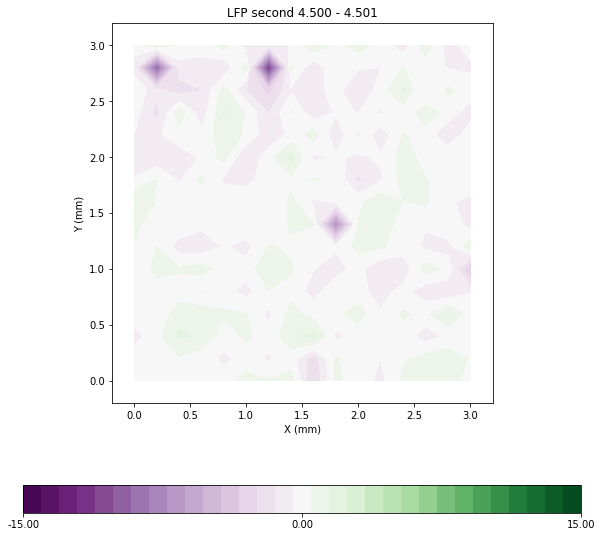

In [169]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_plot(xx, yy, zz, title='True CSD', cmap=cm.bwr):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    
    #t_max either be calculated from the signal or given
    t_max = np.max(np.abs(zz))
    t_max = 15
    levels = np.linspace(-1 * t_max, t_max, 32)
    im = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_title(title)
    #ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')
    ax.set_xlim(-0.2, 3.2)
    ax.set_ylim(-0.2, 3.2)
    ticks = np.linspace(-1 * t_max, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    return ax
make_plot(csd_x, csd_y, a, title='LFP second 4.500 - 4.501', cmap=cm.PRGn)

In [160]:
ele_x, ele_y = np.mgrid[0.00: 3: 16j,
                        0.00: 3: 16j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

In [161]:
from scipy.integrate import simps

def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)                                                                                                           
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

def forward_method(ele_pos, csd_at, true_csd):
    pots = np.zeros(ele_pos.shape[0])
    xlin = csd_at[0, :, 0]
    ylin = csd_at[1, 0, :]
    h = 50.  # distance between the electrode plane and the midslice
    sigma = 1.0 # S/m
    for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
        pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                                [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                                [xlin, ylin])
    pots /= 2 * np.pi * sigma
    return pots

pots = forward_method(ele_pos, csd_at, a)

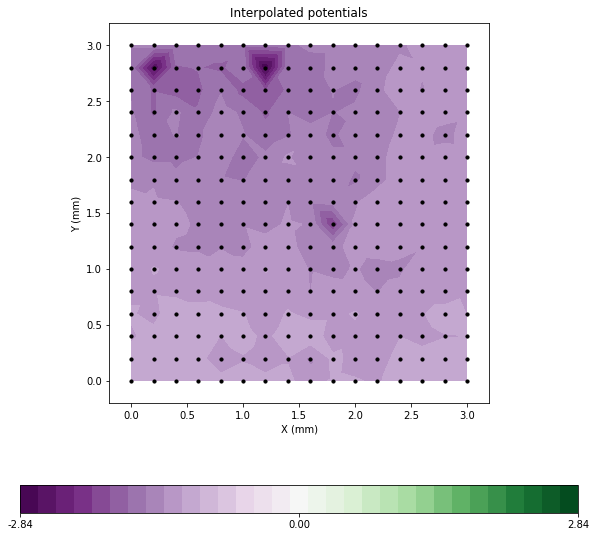

In [162]:
from scipy.interpolate import griddata

def grid(x, y, z):                                                                                                                                                                    
    x = x.flatten()                                                                                                                                                                                             
    y = y.flatten()                                                                                                                                                                                             
    z = z.flatten()                                                                                                                                                                                             
    xi, yi = np.mgrid[min(x):max(x):np.complex(0, 1000),                                                                                                                                                        
                      min(y):max(y):np.complex(0, 1000)]                                                                                                                                                        
    zi = griddata((x, y), z, (xi, yi), method='linear')                                                                                                                                                         
    return xi, yi, zi

pot_X, pot_Y, pot_Z = grid(ele_pos[:, 0], ele_pos[:, 1], pots)
ax = make_plot(pot_X, pot_Y, pot_Z, title='Interpolated potentials', cmap=cm.PRGn)
ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')



Nächste Schritte: Sanity Check: Ergibt das ganz so sinn, was passiert, wenn ich bandpass statt lowpass nehme? welches von beiden macht mehr sinn? Kann ich die Grafik benutzen um das CSD Profil von Elephant zu benutzen?

In [163]:

from kcsd import KCSD2D

def do_kcsd(ele_pos, pots):
    h = 50.  # distance between the electrode plane and the midslice
    sigma = 1.0 # S/m
    pots = pots.reshape((len(ele_pos), 1)) # first time point 
    k = KCSD2D(ele_pos, pots, h=h, sigma=sigma,                                                                                                                                                       
               xmin=0.0, xmax=3.0,
               ymin=0.0, ymax=3.0,
               n_src_init=1000, src_type='gauss', R_init=1.)
    return k

k = do_kcsd(ele_pos, pots)
est_csd = k.values('CSD')



In [164]:
est_csd.shape

(101, 101, 1)

In [165]:
k.values('CSD')

array([[[  1.18176532],
        [  3.44895267],
        [  5.79777431],
        ...,
        [-48.53170753],
        [-46.23003471],
        [-42.52392709]],

       [[  0.38634753],
        [  2.51973248],
        [  4.79104757],
        ...,
        [-54.20461607],
        [-49.9119885 ],
        [-44.04602611]],

       [[ -1.20398641],
        [  0.76320124],
        [  2.94282675],
        ...,
        [-58.55296636],
        [-52.47777605],
        [-44.68109941]],

       ...,

       [[  7.7230885 ],
        [ 10.90473962],
        [ 13.63846684],
        ...,
        [-47.00930822],
        [-46.6366998 ],
        [-46.11368871]],

       [[  4.05381   ],
        [  6.78034449],
        [  9.26403189],
        ...,
        [-54.40410113],
        [-54.05493546],
        [-53.53278816]],

       [[  0.16658497],
        [  2.35796487],
        [  4.50563884],
        ...,
        [-59.44701064],
        [-59.08854759],
        [-58.55901742]]])

<AxesSubplot:title={'center':'Estimated CSD without CV'}, xlabel='X (mm)', ylabel='Y (mm)'>

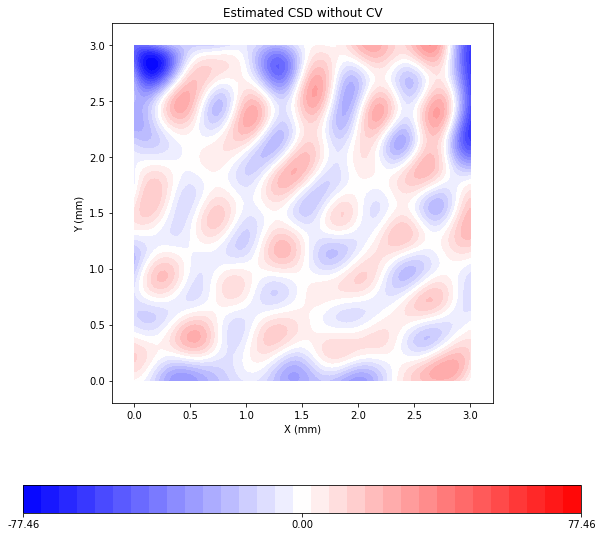

In [166]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD without CV', cmap=cm.bwr)

In [167]:
k.cross_validate(Rs=np.linspace(0.01, 0.15, 15))
est_csd = k.values('CSD')

No lambda given, using defaults
Cross validating R (all lambda) : 0.01
Cross validating R (all lambda) : 0.019999999999999997
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.039999999999999994
Cross validating R (all lambda) : 0.049999999999999996
Cross validating R (all lambda) : 0.05999999999999999
Cross validating R (all lambda) : 0.06999999999999999
Cross validating R (all lambda) : 0.07999999999999999
Cross validating R (all lambda) : 0.08999999999999998
Cross validating R (all lambda) : 0.09999999999999998
Cross validating R (all lambda) : 0.10999999999999997
Cross validating R (all lambda) : 0.11999999999999998
Cross validating R (all lambda) : 0.12999999999999998
Cross validating R (all lambda) : 0.13999999999999999
Cross validating R (all lambda) : 0.15
R, lambda : 0.01 0.01


<AxesSubplot:title={'center':'Estimated CSD with CV'}, xlabel='X (mm)', ylabel='Y (mm)'>

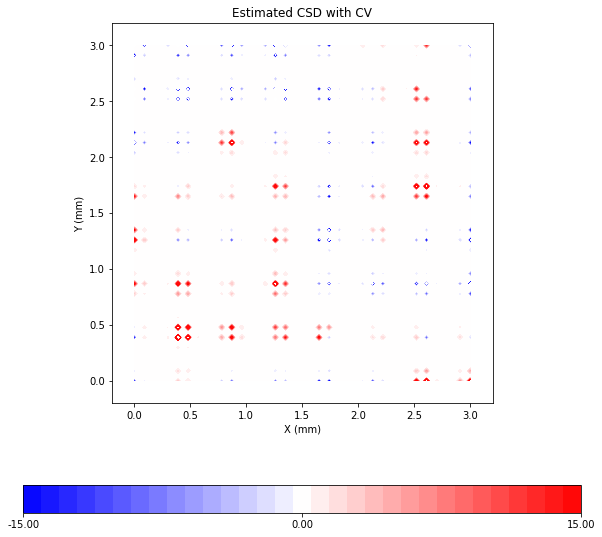

In [172]:
make_plot(k.estm_x, k.estm_y, est_csd[:, :, 0], 
          title='Estimated CSD with CV', cmap=cm.bwr) # First time point

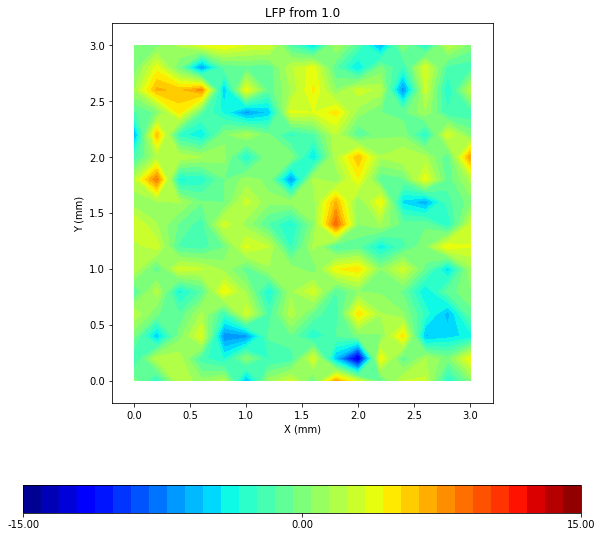

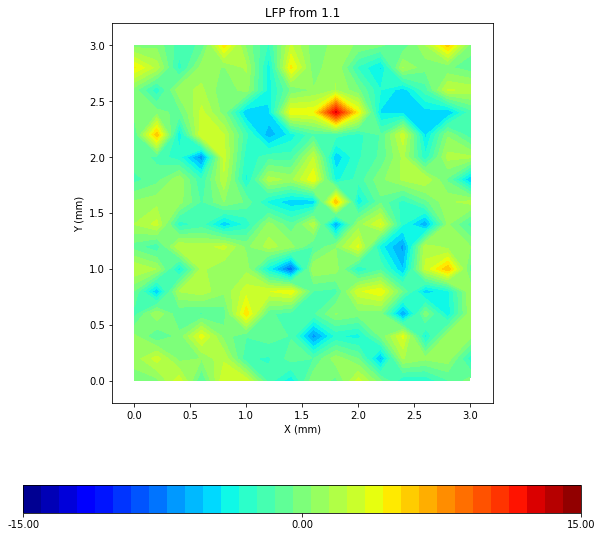

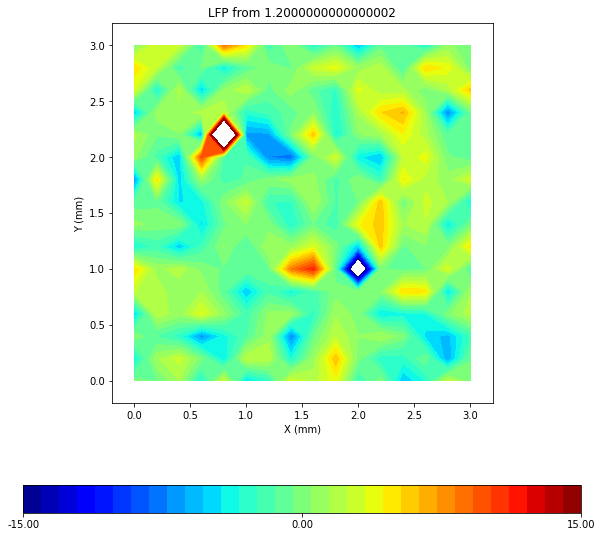

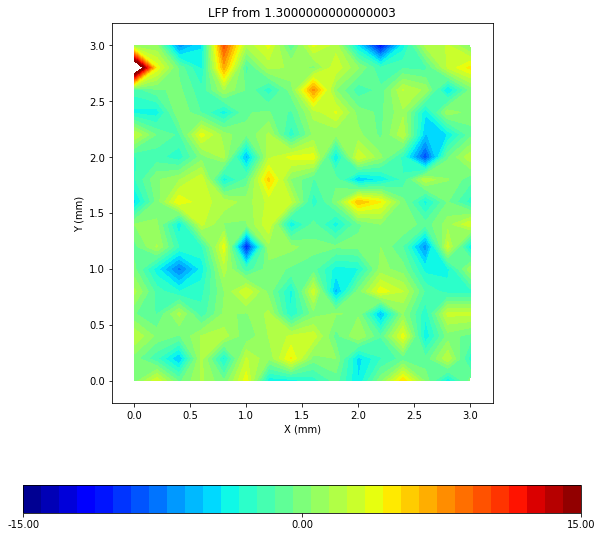

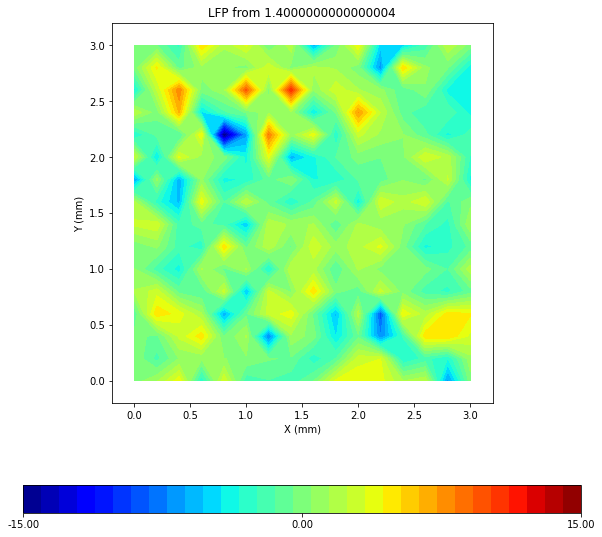

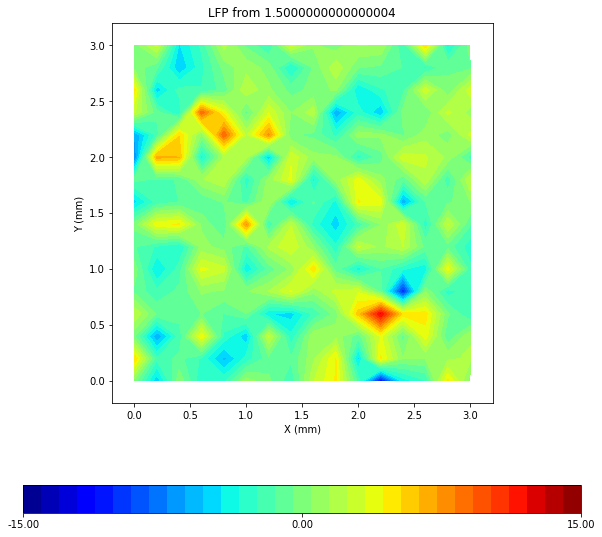

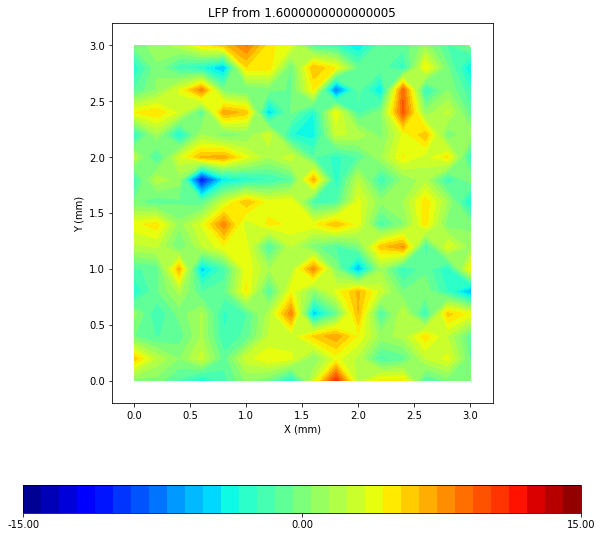

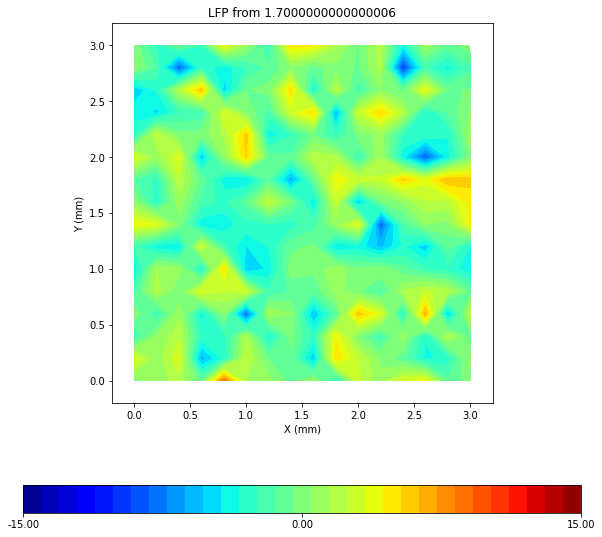

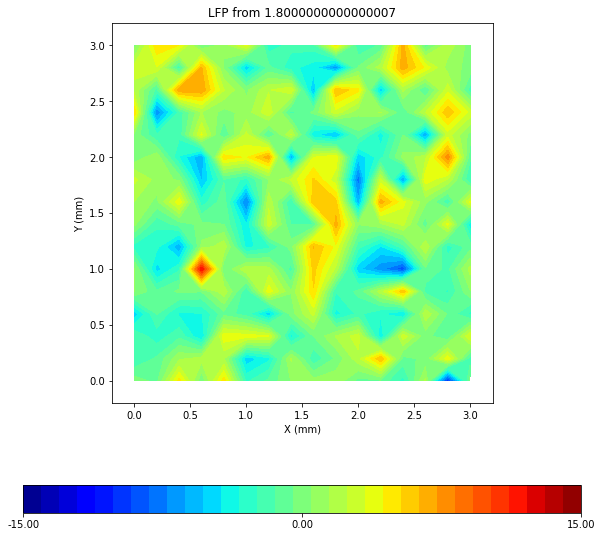

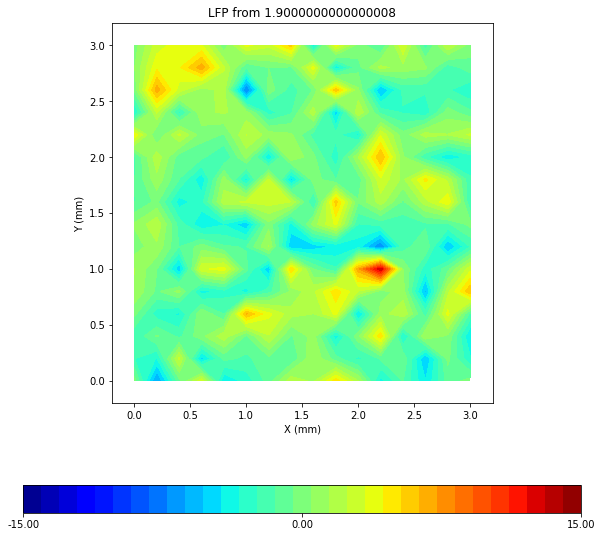

In [134]:
for i in np.arange(1, 2, 0.1):
    
    a, b= return_mea_lfp(bandpass_dic, timepoint=i, timerange=0.0)
    make_plot(csd_x, csd_y, a, title='LFP from '+str(i), cmap=cm.jet)

In [112]:
from elephant.current_source_density import estimate_csd
import neo
from neo.core import AnalogSignal
import quantities as pq

In [123]:
channel_coord

{'R12': (3.0, 0.8),
 'L10': (2.0, 1.2),
 'O10': (2.6, 1.2),
 'P11': (2.8, 1.0),
 'L9': (2.0, 1.4),
 'N9': (2.4, 1.4),
 'M8': (2.2, 1.6),
 'R8': (3.0, 1.6),
 'O6': (2.6, 2.0),
 'N7': (2.4, 1.8),
 'R4': (3.0, 2.4),
 'P5': (2.8, 2.2),
 'R2': (3.0, 2.8),
 'M5': (2.2, 2.2),
 'K6': (1.8, 2.0),
 'I8': (1.6, 1.6),
 'L2': (2.0, 2.8),
 'M1': (2.2, 3.0),
 'I4': (1.6, 2.4),
 'K3': (1.8, 2.6),
 'H1': (1.4, 3.0),
 'I6': (1.6, 2.0),
 'G4': (1.2, 2.4),
 'H5': (1.4, 2.2),
 'E2': (0.8, 2.8),
 'F3': (1.0, 2.6),
 'N13': (2.4, 0.6),
 'O14': (2.6, 0.4),
 'R13': (3.0, 0.6),
 'L11': (2.0, 1.0),
 'O11': (2.6, 1.0),
 'P12': (2.8, 0.8),
 'M9': (2.2, 1.4),
 'N10': (2.4, 1.2),
 'L8': (2.0, 1.6),
 'R9': (3.0, 1.4),
 'O7': (2.6, 1.8),
 'N8': (2.4, 1.6),
 'R5': (3.0, 2.2),
 'P6': (2.8, 2.0),
 'K7': (1.8, 1.8),
 'L7': (2.0, 1.8),
 'N4': (2.4, 2.4),
 'O3': (2.6, 2.6),
 'N1': (2.4, 3.0),
 'L6': (2.0, 2.0),
 'L3': (2.0, 2.6),
 'M2': (2.2, 2.8),
 'I5': (1.6, 2.2),
 'K4': (1.8, 2.4),
 'H6': (1.4, 2.0),
 'I1': (1.6, 3.0),
 

In [113]:
# make an array of arrays from the bandpass dic

neo_signal_list = []
for k, v in bandpass_dic.items():
    neo_signal_list.append(list(v))
    

In [124]:
# make an array of arrays from the bandpass dic

coordinates_list = []
for k, v in channel_coord.items():
    coordinates_list.append(list(v))

In [125]:
coordinates_list

[[3.0, 0.8],
 [2.0, 1.2],
 [2.6, 1.2],
 [2.8, 1.0],
 [2.0, 1.4],
 [2.4, 1.4],
 [2.2, 1.6],
 [3.0, 1.6],
 [2.6, 2.0],
 [2.4, 1.8],
 [3.0, 2.4],
 [2.8, 2.2],
 [3.0, 2.8],
 [2.2, 2.2],
 [1.8, 2.0],
 [1.6, 1.6],
 [2.0, 2.8],
 [2.2, 3.0],
 [1.6, 2.4],
 [1.8, 2.6],
 [1.4, 3.0],
 [1.6, 2.0],
 [1.2, 2.4],
 [1.4, 2.2],
 [0.8, 2.8],
 [1.0, 2.6],
 [2.4, 0.6],
 [2.6, 0.4],
 [3.0, 0.6],
 [2.0, 1.0],
 [2.6, 1.0],
 [2.8, 0.8],
 [2.2, 1.4],
 [2.4, 1.2],
 [2.0, 1.6],
 [3.0, 1.4],
 [2.6, 1.8],
 [2.4, 1.6],
 [3.0, 2.2],
 [2.8, 2.0],
 [1.8, 1.8],
 [2.0, 1.8],
 [2.4, 2.4],
 [2.6, 2.6],
 [2.4, 3.0],
 [2.0, 2.0],
 [2.0, 2.6],
 [2.2, 2.8],
 [1.6, 2.2],
 [1.8, 2.4],
 [1.4, 2.0],
 [1.6, 3.0],
 [1.2, 2.6],
 [1.4, 2.4],
 [0.8, 3.0],
 [1.0, 2.8],
 [1.8, 0.6],
 [2.0, 0.0],
 [1.6, 0.8],
 [1.8, 0.2],
 [1.6, 0.0],
 [1.6, 0.4],
 [1.8, 1.2],
 [2.6, 0.0],
 [3.0, 0.4],
 [3.0, 0.2],
 [2.6, 0.8],
 [2.8, 0.6],
 [2.2, 1.2],
 [2.4, 1.0],
 [2.8, 1.4],
 [3.0, 1.2],
 [2.6, 1.6],
 [1.8, 1.6],
 [3.0, 2.0],
 [2.8, 1.8],
 [2.4, 2.2],

In [118]:
# transpose the signal, because for neo takes time as dimension 0 and channel idx as dimenion 1
neo_signal_trans = np.transpose(neo_signal_list)

In [121]:
neo_signal_trans.shape

(250001, 252)

In [119]:
analog_signal = AnalogSignal(neo_signal_trans, units='mV', sampling_rate=25000*pq.Hz)

In [120]:
analog_signal

AnalogSignal with 252 channels of length 250001; units mV; datatype float64 
sampling rate: 25000.0 Hz
time: 0.0 s to 10.00004 s

In [126]:
elephant_CSD = estimate_csd(analog_signal, coordinates=coordinates_list)

AttributeError: No units given for electrode spatial                 coordinates

In [101]:
# change the bandpassfiltered signal to a neo AnalogSignal
# then add the electrode positions
bandpass_dic

{'R12': array([-0.4135863 , -1.99085585, -3.90757765, ...,  3.12907236,
         3.69637963,  4.16427122]),
 'L10': array([-0.33405047, -1.40212352, -1.38990048, ...,  5.4683446 ,
        10.52401117, 14.24871064]),
 'O10': array([-0.0477215 , -0.41845877, -1.50135818, ..., -1.20305006,
        -2.17745078, -1.78379236]),
 'P11': array([0.20679315, 1.07098696, 2.25976292, ..., 1.89319218, 1.8043492 ,
        5.12913286]),
 'L9': array([0.46926138, 2.10789055, 3.25772554, ..., 6.86106453, 3.5574352 ,
        1.76597512]),
 'N9': array([-0.0477215 , -0.15599054,  0.25932144, ...,  1.47162074,
        -1.10995633, -4.06041411]),
 'M8': array([-0.42949347, -2.21518032, -4.77990616, ...,  0.31576412,
        -1.00765747, -2.98497432]),
 'R8': array([ 0.27042181,  1.27632315,  2.3299678 , ..., -0.21896399,
        -1.41794158, -1.32702573]),
 'O6': array([-0.03976791, -0.02792114,  0.91981017, ..., -4.56131486,
        -5.36842212, -2.99499942]),
 'N7': array([ 0.1829324 ,  0.9412934 ,  1.65

In [50]:
# insert the channel you want to observe
observed_channel = 'E5'
channellabel = observed_channel

lowpasssignal = lowpass_dic[observed_channel][:250000]
bandpassfilteredsignal = bandpass_dic[observed_channel][:250000]

In [51]:
lowpasssignal.shape

(250000,)

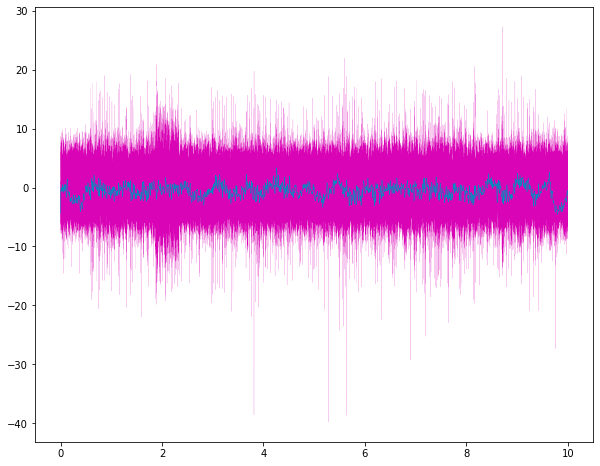

In [55]:
# plot the signal and the filter

fig, ax = plt.subplots(1, 1, figsize = (10,8))


ax.plot(time_in_sec[:250000], bandpassfilteredsignal, c = '#D904B5', linewidth = 0.1)
ax.plot(time_in_sec[:250000], lowpasssignal, c = '#048ABF',  linewidth = 0.5)

In [33]:
# Filter requirements.
T = timelengthrecording_s         # Sample Period
fs = fs      # sample rate, Hz
cutoff = 50      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

In [34]:
nyq

12500.0

In [35]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [36]:
butter_lowpass_filtered_signal = butter_lowpass_filter(signal_in_uV, cutoff, fs, order)

No handles with labels found to put in legend.


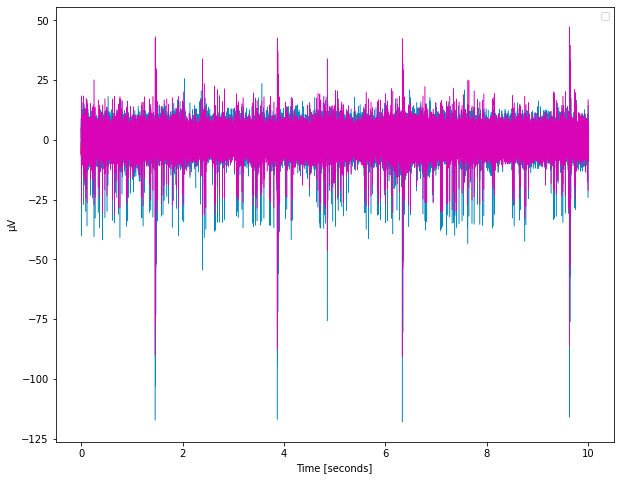

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))

ax.plot(time_in_sec, signal_in_uV, c = '#048ABF',  linewidth = 0.5)
ax.plot(time_in_sec, butter_lowpass_filtered_signal, c = '#F20505', linewidth = 1.5)
ax.plot(time_in_sec, bandpassfilteredsignal, c = '#D904B5', linewidth = 0.5)
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('µV')
ax.legend()

In [189]:
butter_lowpass_filtered_signal

array([-5.71269985, -5.66750574, -5.62238792, ...,  1.81056122,
        1.81043459,  1.81032822])

In [190]:
noise_mad = np.median(np.absolute(bandpassfilteredsignal)) / 0.6745
threshold = -5* noise_mad
artefact_threshold = -8* noise_mad
crossings = detect_threshold_crossings(
    bandpassfilteredsignal, sampling_frequency, 
    threshold, dead_time=0.003
    )
spikes=align_to_minimum(
    bandpassfilteredsignal, fs, crossings, search_range=0.003, 
    first_time_stamp=first_recording_timepoint
    )

In [191]:
spikes

array([   317,   2358,   2934,   6371,   6923,   8426,   9174,  10690,
        11771,  12796,  15573,  16371,  18545,  19168,  22411,  22938,
        29651,  30000,  30561,  33835,  34095,  34379,  35426,  36478,
        36683,  36883,  37075,  37523,  37722,  39556,  40385,  40910,
        42275,  43070,  44916,  46967,  47895,  49924,  50640,  59881,
        60667,  61049,  61524,  65770,  66176,  67182,  68262,  69787,
        70587,  76543,  76959,  77424,  77641,  79292,  79827,  84621,
        85037,  86001,  86627,  86717,  88344,  89095,  90134,  92752,
        93409,  95047,  96648,  96850,  97034,  97252,  97683, 100818,
       101428, 103529, 104152, 109045, 112662, 116747, 117372, 117752,
       118164, 119891, 120601, 121298, 121620, 122576, 123380, 124088,
       124633, 125483, 126697, 127762, 129208, 139606, 139969, 140479,
       141618, 142894, 143561, 146077, 146584, 147570, 149405, 150170,
       151099, 152907, 153657, 155766, 156806, 158263, 158456, 158652,
      

<IPython.core.display.Javascript object>


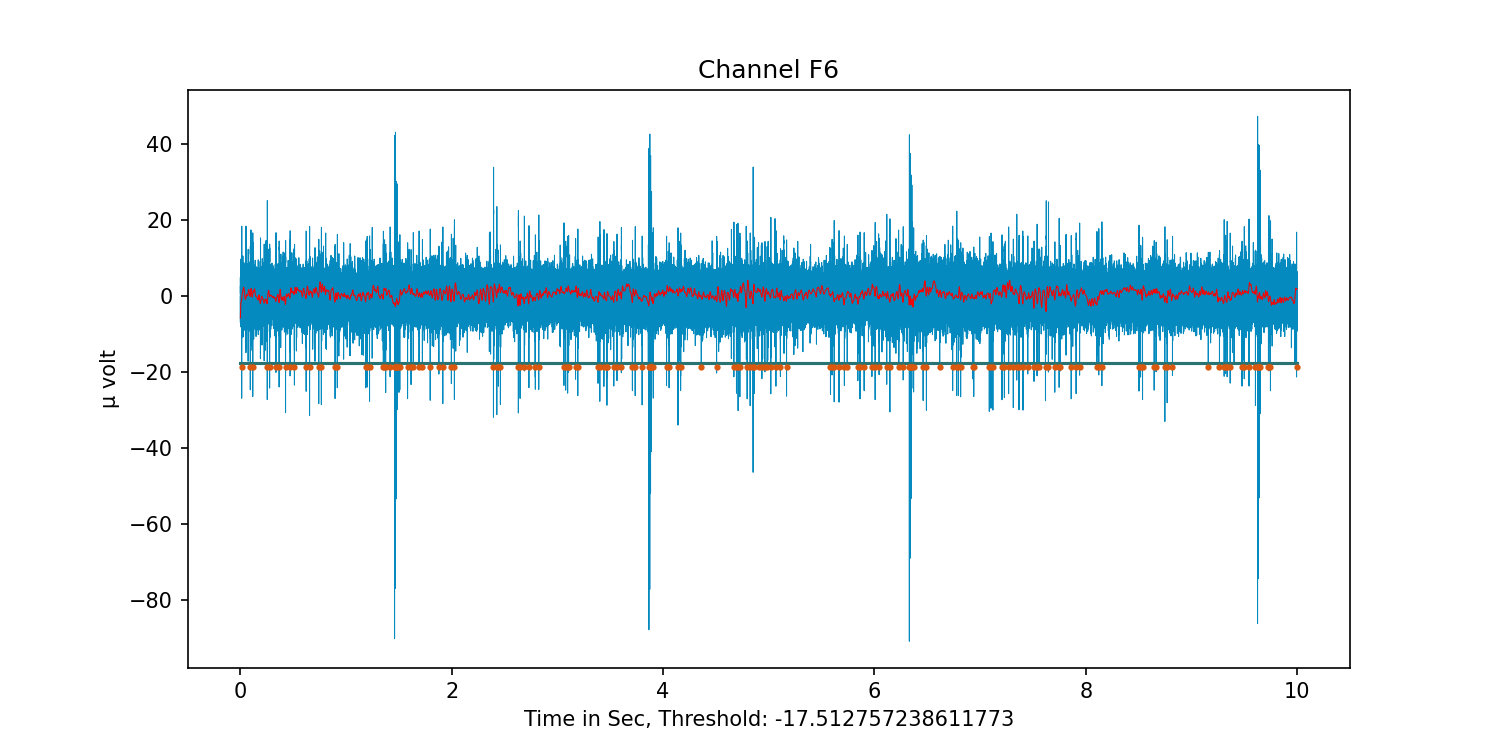

<ipython-input-192-3d89a1c96259>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [192]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [threshold, threshold], c="#297373")
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec, Threshold: %s' %threshold)
ax = plt.ylabel('µ volt')

fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP.png')

In [193]:
len(butter_lowpass_filtered_signal)

250001

In [194]:
# we want to find where the lfp passes a mean threshold

lfp_mean = np.mean(butter_lowpass_filtered_signal)
lfp_std = np.std(butter_lowpass_filtered_signal)

In [195]:
lfp_mean, lfp_std

(0.5320998215059836, 1.1368171941743068)

In [214]:
def lfp_crossing_detection(lowpass_filtered_signal, lfp_threshold):

    # dicts will have tuples with a start and stop of the lfp crossing
    lfp_up_crossing = []
    lfp_down_crossing = []
    
    # lfp crosses below threshold
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] < -lfp_threshold) and (lowpass_filtered_signal[i-1] >= -lfp_threshold):
            start = i
            while (lowpass_filtered_signal[i] < -lfp_threshold) and (i < len(lowpass_filtered_signal-1):
                stop = i
                i += 1
            lfp_down_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
    # lfp crosses above threshold
    
    for i in range(0, len(lowpass_filtered_signal)-1):
        start = 0
        stop = 0
        if (lowpass_filtered_signal[i] > lfp_threshold) and (lowpass_filtered_signal[i-1] <= lfp_threshold):
            start = i
            while (lowpass_filtered_signal[i] > lfp_threshold) and (i < len(lowpass_filtered_signal-1)):
                
                stop = i
                i += 1
            lfp_up_crossing.append((start*scale_factor_for_second*tick, stop*scale_factor_for_second*tick))
            
            
    return lfp_down_crossing, lfp_up_crossing
            
            
    

SyntaxError: invalid syntax (<ipython-input-214-b027a9e87299>, line 13)

In [215]:
down_cross, up_cross = lfp_crossing_detection(butter_lowpass_filtered_signal, (3*lfp_std))

In [216]:
down_cross

[(0.0, 0.00224), (7.6206, 7.625799999999999)]

In [217]:
up_cross

[(0.75172, 0.7574799999999999),
 (2.03236, 2.0358799999999997),
 (4.75672, 4.7613199999999996),
 (4.79852, 4.80564),
 (6.473559999999999, 6.481319999999999),
 (6.5542, 6.57276),
 (7.2574, 7.26128),
 (7.274039999999999, 7.283759999999999),
 (9.54696, 9.55148)]

<IPython.core.display.Javascript object>


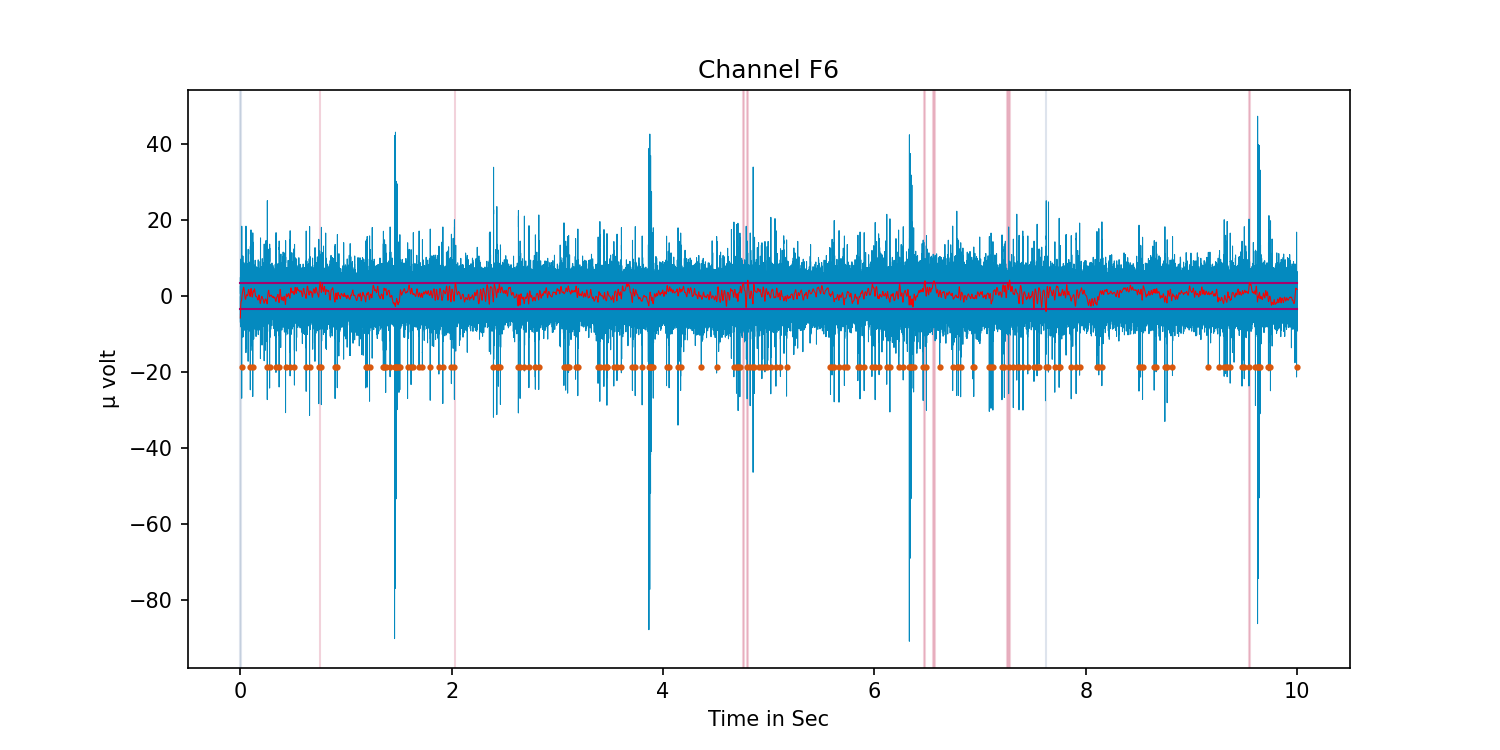

<ipython-input-206-e16e35b49c64>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")


In [206]:
# plot the lfps

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plt.plot(time_in_sec, bandpassfilteredsignal, c="#048ABF", linewidth = 0.5)
#ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [lfp_mean, lfp_mean], c="#297373", lw=1)
ax = plt.plot(spikes*tick*scale_factor_for_second, [threshold-1]*(spikes*tick*scale_factor_for_second).shape[0], 'ro', ms=2, c="#D9580D")
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [3*lfp_std, 3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot([time_in_sec[0], time_in_sec[-1]], [-3*lfp_std, -3*lfp_std], c="#A6036D", lw=1)
ax = plt.plot(time_in_sec, butter_lowpass_filtered_signal, c='#F20505', linewidth=0.5)
for i in down_cross:
    ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
for i in up_cross:
    ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)

ax = plt.title('Channel %s' %channellabel)
ax = plt.xlabel('Time in Sec')
ax = plt.ylabel('µ volt')

fig.savefig(filebase+'_signal_'+channellabel+'_Spikes_and_LFP_ax_v.png')

In [219]:
os.getcwd()

'D:\\Files_Reutlingen_Jenny\\19-04-16\\190416_h5'

In [201]:
lowpass_dic

{'R12': array([-5.40731824, -5.34941796, -5.29153488, ...,  0.69765651,
         0.69771435,  0.69776041]),
 'L10': array([-3.78970613, -3.76204916, -3.73444667, ..., -0.11859162,
        -0.11858233, -0.11856961]),
 'O10': array([ 0.2844296 ,  0.29095122,  0.29752921, ..., 11.64993948,
        11.65002104, 11.65008736]),
 'P11': array([1.86308031, 1.83476298, 1.80649406, ..., 1.810746  , 1.81084812,
        1.81093579]),
 'L9': array([ 4.99649771,  4.96343688,  4.93033768, ..., -0.20928289,
        -0.2092425 , -0.2092059 ]),
 'N9': array([-3.7808846 , -3.73806696, -3.69529163, ...,  1.40756469,
         1.40757694,  1.40758326]),
 'M8': array([-5.13857288, -5.08627538, -5.03395654, ...,  1.10900821,
         1.10904496,  1.10907277]),
 'R8': array([5.78992001, 5.74104326, 5.69217996, ..., 1.22372431, 1.22373107,
        1.22373645]),
 'O6': array([ 0.29611945,  0.29869528,  0.30128464, ..., -0.79511693,
        -0.79497354, -0.7948561 ]),
 'N7': array([ 0.60871318,  0.59216074,  0.57

In [218]:
# for every channel in our lowpass_dictionary, we want the std*3 for threshold

lowpass_threshold_dic = {}
up_crossing_dic = {}
down_crossing_dic = {}

for key in lowpass_dic:
    std = np.std(lowpass_dic[key][0])
    lowpass_threshold_dic[key] = std*3
    

# we want the up crossings of the lfp
# and the donwcrossings of the lfp

for key in lowpass_dic:
    
    threshold = lowpass_threshold_dic[key]
    low_signal = lowpass_dic[key]
    
    down_cross, up_cross = lfp_crossing_detection(
        low_signal, threshold)
    
    up_crossing_dic[key] = up_cross
    down_crossing_dic[key] = down_cross

IndexError: index 250001 is out of bounds for axis 0 with size 250001

In [207]:
interesting_LFP = ['I2', 'I3', 'K2', 'K3', 'J13', 'J14', 'K13', 'K14', 'F15', 'E15']

In [208]:
fig = plt.figure(figsize=(10,10))
limit0 = 89.3
limit1 = 91.2


windowsize = 0.2 #in seconds
win = limit0
windows = []
while win < limit1:
    if win + windowsize >= limit1:
        win = limit1
        windows.append(win)
    else:
        windows.append(win)
        win += windowsize

number_interesting_LFP = len(interesting_LFP)
#fig.tight_layout()
gs1 = gridspec.GridSpec(number_interesting_LFP, 1)
gs1.update(wspace=0.025, hspace=0.05) 
axs = []

for i in range(1, len(interesting_LFP)+1):
    
    # get the key of the channel
    key = interesting_LFP[i-1]
    
    #no get all signals to plot and the lfp_down and lfp_ups
    bandpass_signal = bandpass_dic[key]
    # in the lowpass_dic there are still additional returns from the old butter filter function
    lowpass_signal = lowpass_dic[key][0]
    lfp_ups = up_crossing_dic[key]
    lfp_downs = down_crossing_dic[key]
    
    
    axs.append(fig.add_subplot(gs1[i-1]))
    
    
    axs[-1] = plt.plot(time_in_sec, bandpass_signal, c="#048ABF", linewidth = 0.5)
    axs[-1] = plt.plot(time_in_sec, lowpass_signal, c='#F20505', linewidth=1)
    
    # spikes may be added additionally
    #axs[-1] = plt.plot(spikes*tick*scale_factor_for_second, 
     #                  [100]*(spikes*tick*scale_factor_for_second).shape[0], 
      #                 'ro', ms=2, c="#D9580D")

    
    for i in lfp_downs:
        ax = plt.axvspan(i[0], i[1], color='#5D7CA6', alpha=0.2)
    for i in lfp_ups:
        ax = plt.axvspan(i[0], i[1], color='#BF214B', alpha=0.2)
    for i in windows:
        ax = plt.axvline(i)
    
    # plt xlim for zooming in the time
    plt.xlim(limit0, limit1)    
    plt.yticks(fontsize='xx-small')
    plt.ylabel(key)
    #plt.ylim(-100, 100)
    

fig.suptitle(filebase + ' lfp + banbpass from '+str(limit0)+' to '+str(limit1))
fig.savefig(
    filebase + '_lfp_and_bandpasssignal_cutout_from_' + str(limit0) +'_to_'+str(limit1)+'.png',
    bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>

KeyError: 'I2'

In [210]:
up_crossing_dic

{}

In [104]:
lowpass_signal

(array([5.68900865, 5.66306546, 5.63711961, ..., 1.78719673, 1.78716393,
        1.78713201]),
 array([3.91302054e-05, 7.82604108e-05, 3.91302054e-05]),
 array([ 1.        , -1.98222893,  0.98238545]))

In [87]:
bandpass_dic

{'G13': array([0.15240587, 0.98626915, 2.85086618, ..., 4.41586878, 6.29010552,
        8.28649551]),
 'G12': array([ 0.64948349,  3.45910291,  7.87847738, ..., -1.65921053,
        -2.68900204, -1.96463   ]),
 'F16': array([0.20867881, 1.11628415, 2.44812598, ..., 2.22131436, 2.74884864,
        4.74255338]),
 'F15': array([ 0.81126818,  4.26813203,  9.56608197, ..., -6.68994557,
        -4.40205936, -1.73453422]),
 'F14': array([ 0.29777763,  1.54977308,  3.31574514, ..., -1.0963439 ,
        -1.03260022, -1.08972174]),
 'F13': array([0.1617847 , 0.98722675, 2.6202342 , ..., 1.36133291, 0.58687532,
        0.21216949]),
 'F12': array([ 0.88395406,  4.62491457, 10.20126516, ..., -2.62601538,
        -2.77000523, -3.05608211]),
 'E16': array([ 0.75968466,  3.86895467,  8.11199533, ..., -1.66490566,
        -3.49241667, -4.3414667 ]),
 'E15': array([ 0.1219247 ,  0.8377852 ,  2.53280444, ..., -0.23542396,
         1.13167213,  1.79729714]),
 'E14': array([ 0.08909882,  0.64216774,  2.26

In [ ]:
fig = plt.figure(figsize=(20,8))

fig.tight_layout()
fig.suptitle('Burst Propagation from ' + 
             str(np.round(b_of_interest_start, 4))+ ' to ' + 
             str(np.round(b_of_interest_end, 4)))
gs1 = gridspec.GridSpec(2, 5)

#countries = ["Country " + str(i) for i in range(1, 26)]
axs = []
time_intra_burst = 0

for i in range(1, len(time_windows)+1):
    

    plotframe = copy.deepcopy(df)
    
    # get the key for the fr_dic from the time windows:
    key = time_windows[i-1][0] # substract one because we start the for range at 1
    
    #extract the corresponding fr_dic
    fr_dic = subdivided_boi_fr[key]
    
    # fill the dataframe
    plotframe_filled = get_dict_values(plotframe, fr_dic)
    
    axs.append(fig.add_subplot(gs1[i-1]))
    # plot the heatmap
    #sns.heatmap(plotframe_filled, annot=False, linewidths=.5, ax=axstring, cmap="YlOrRd")


    axs[-1] = sns.heatmap(plotframe_filled, 
                          annot=False, vmin=0, vmax = 20, cmap='flare', 
                          cbar = False, linewidths=0.1)
    
    
    plt.setp(axs[-1], 
             title=str(int(time_intra_burst)) + ' ms')
    
    time_intra_burst += (heatmap_window*1000)

fig.savefig('divided_burst_spatial_10082021_b25.png', dpi=300, bbox_inches = 'tight')

In [42]:
np.linspace(0, 2 * np.pi, num=100)

array([0.        , 0.06346652, 0.12693304, 0.19039955, 0.25386607,
       0.31733259, 0.38079911, 0.44426563, 0.50773215, 0.57119866,
       0.63466518, 0.6981317 , 0.76159822, 0.82506474, 0.88853126,
       0.95199777, 1.01546429, 1.07893081, 1.14239733, 1.20586385,
       1.26933037, 1.33279688, 1.3962634 , 1.45972992, 1.52319644,
       1.58666296, 1.65012947, 1.71359599, 1.77706251, 1.84052903,
       1.90399555, 1.96746207, 2.03092858, 2.0943951 , 2.15786162,
       2.22132814, 2.28479466, 2.34826118, 2.41172769, 2.47519421,
       2.53866073, 2.60212725, 2.66559377, 2.72906028, 2.7925268 ,
       2.85599332, 2.91945984, 2.98292636, 3.04639288, 3.10985939,
       3.17332591, 3.23679243, 3.30025895, 3.36372547, 3.42719199,
       3.4906585 , 3.55412502, 3.61759154, 3.68105806, 3.74452458,
       3.8079911 , 3.87145761, 3.93492413, 3.99839065, 4.06185717,
       4.12532369, 4.1887902 , 4.25225672, 4.31572324, 4.37918976,
       4.44265628, 4.5061228 , 4.56958931, 4.63305583, 4.69652

In [43]:
np.cos(np.linspace(0, 2 * np.pi, num = 100))

array([ 1.        ,  0.99798668,  0.99195481,  0.9819287 ,  0.9679487 ,
        0.95007112,  0.92836793,  0.90292654,  0.87384938,  0.84125353,
        0.80527026,  0.76604444,  0.72373404,  0.67850941,  0.63055267,
        0.58005691,  0.52722547,  0.47227107,  0.41541501,  0.35688622,
        0.29692038,  0.23575894,  0.17364818,  0.1108382 ,  0.04758192,
       -0.01586596, -0.07924996, -0.14231484, -0.20480667, -0.26647381,
       -0.32706796, -0.38634513, -0.44406661, -0.5       , -0.55392006,
       -0.60560969, -0.65486073, -0.70147489, -0.74526445, -0.78605309,
       -0.82367658, -0.85798341, -0.88883545, -0.91610846, -0.93969262,
       -0.95949297, -0.97542979, -0.98743889, -0.99547192, -0.99949654,
       -0.99949654, -0.99547192, -0.98743889, -0.97542979, -0.95949297,
       -0.93969262, -0.91610846, -0.88883545, -0.85798341, -0.82367658,
       -0.78605309, -0.74526445, -0.70147489, -0.65486073, -0.60560969,
       -0.55392006, -0.5       , -0.44406661, -0.38634513, -0.32

In [47]:
sig_neo = AnalogSignal(bandpassfilteredsignal, sampling_rate=25000*pq.Hz, units='mV')

In [48]:
sig_neo

AnalogSignal with 1 channels of length 3010000; units mV; datatype float64 
sampling rate: 25000.0 Hz
time: 0.0 s to 120.4 s

In [52]:
freq, psd = welch_psd(sig_neo)

In [53]:
freq, psd

(array([0.00000000e+00, 3.73754650e-02, 7.47509299e-02, ...,
        1.24999252e+04, 1.24999626e+04, 1.25000000e+04]) * Hz,
 array([[3.37487892e-08, 1.68743888e-08, 5.46382557e-22, ...,
         3.81985992e-32, 3.97097524e-32, 1.95987874e-32]]) * mV**2/Hz)

In [54]:
freq.shape

(334445,)

In [55]:
psd.shape

(1, 334445)

<IPython.core.display.Javascript object>


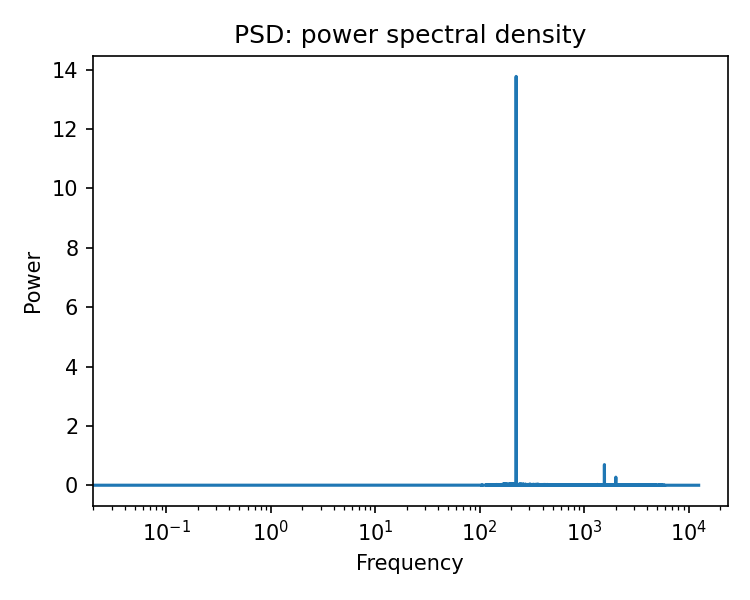

In [61]:


plt.figure(figsize=(5, 4))
plt.semilogx(freq, psd[0])
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()